In [5]:
from src.Base.Evaluation.Evaluator import EvaluatorHoldout
import numpy as np
from src.Utils.load_ICM import load_ICM
from src.Utils.load_URM import load_URM

import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

URM_all = load_URM("in/data_train.csv")
ICM_all = load_ICM("in/data_ICM_title_abstract.csv")

from src.Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.80)

In [6]:
from src.Utils.ICM_preprocessing import *
from src.GraphBased.P3alphaRecommender import P3alphaRecommender
from src.GraphBased.RP3betaCBFRecommender import RP3betaCBFRecommender
from src.Hybrid.SimilarityMergedHybridRecommender import SimilarityMergedHybridRecommender
from src.Hybrid.GeneralizedSimilarityMergedHybridRecommender import GeneralizedSimilarityMergedHybridRecommender
from src.Base.NonPersonalizedRecommender import TopPop
from src.MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
from src.EASE_R.EASE_R_Recommender import EASE_R_Recommender
ICM_combined = combine(ICM=ICM_all, URM = URM_train)

p3alpha_recommender = P3alphaRecommender(URM_train=URM_train)
p3alpha_recommender.fit(topK=221,alpha=0.5017,implicit=True)

rp3betaCBF_recommender = RP3betaCBFRecommender(URM_train=URM_train, ICM_train=ICM_combined)
rp3betaCBF_recommender.fit(topK=586, alpha=0.4228, beta=0.1918, implicit=False)

p3alpha_featurecombinedrp3beta_recommender = SimilarityMergedHybridRecommender(
    URM_train=URM_train,
    CFRecommender=p3alpha_recommender,
    CBFRecommender=rp3betaCBF_recommender
)
p3alpha_featurecombinedrp3beta_recommender.fit(topK=355, alpha=0.2222)

#pureSVDitem_recommender = PureSVDItemRecommender(URM_train)
#pureSVDitem_recommender.fit(num_factors=448,topK=462)

# easer_recommender = EASE_R_Recommender(URM_train, sparse_threshold_quota=1.0)
# easer_recommender.fit(**{"l2_norm": 41476.92126107723, "topK": 56})


p3alpha_recommender.fit(
    topK=int(212.8832860130684),
    alpha=0.4729294763382114,
    implicit=True
)

rp3betaCombined_recommender = RP3betaCBFRecommender(
    URM_train=URM_train,
    ICM_train=ICM_combined,
    verbose=False
)

rp3betaCombined_recommender.fit(
    topK=int(525.3588205773788),
    alpha=0.42658191175355076,
    beta=0.2284685880641364,
    implicit=False
)

rp3betaCBF_recommender = RP3betaCBFRecommender(
    URM_train=URM_train,
    ICM_train=ICM_all,
    verbose=False
)

rp3betaCBF_recommender.fit(
    topK=int(188.6),
    alpha=0.1324,
    beta=0.981,
    implicit=False
)

p3alpha_featurecombinedrp3beta_rp3betacf_recommender = GeneralizedSimilarityMergedHybridRecommender(
    URM_train,
    similarityRecommenders=[
        p3alpha_recommender,
        rp3betaCombined_recommender,
        rp3betaCBF_recommender
    ]
)

p3alpha_featurecombinedrp3beta_rp3betacf_recommender.fit(
    topKs=[
        int(482.3259592432915),
        int(872.7)
    ],
    alphas=[
        0.2324902889610141,
        0.7876
    ]
)

topPop = TopPop(URM_train)
topPop.fit()

P3alphaRecommender: URM Detected 82 (1.03 %) cold users.
P3alphaRecommender: URM Detected 2424 (9.33 %) cold items.
RP3betaCBFRecommender: URM Detected 82 (1.03 %) cold users.
RP3betaCBFRecommender: URM Detected 2424 (9.33 %) cold items.
RP3betaRecommender: URM Detected 84 (0.30 %) cold users.
RP3betaRecommender: URM Detected 2 (0.01 %) cold items.
P3alphaRP3betaCBFHybridRecommender: URM Detected 82 (1.03 %) cold users.
P3alphaRP3betaCBFHybridRecommender: URM Detected 2424 (9.33 %) cold items.
P3alphaRP3betaCBFRP3betaCBFHybridRecommender: URM Detected 82 (1.03 %) cold users.
P3alphaRP3betaCBFRP3betaCBFHybridRecommender: URM Detected 2424 (9.33 %) cold items.
ItemKNNSimilarityHybridRecommender: URM Detected 82 (1.03 %) cold users.
ItemKNNSimilarityHybridRecommender: URM Detected 2424 (9.33 %) cold items.
ItemKNNSimilarityHybridRecommender: URM Detected 82 (1.03 %) cold users.
ItemKNNSimilarityHybridRecommender: URM Detected 2424 (9.33 %) cold items.
TopPopRecommender: URM Detected 82 (1

In [7]:
profile_length = np.ediff1d(URM_train.indptr)
block_size = int(len(profile_length)*0.1)
sorted_users = np.argsort(profile_length)


In [8]:
for group_id in range(0, 10):

    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id,
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))

Group 0, average p.len 1.15, min 0, max 2
Group 1, average p.len 2.00, min 2, max 2
Group 2, average p.len 2.65, min 2, max 3
Group 3, average p.len 3.22, min 3, max 4
Group 4, average p.len 4.13, min 4, max 5
Group 5, average p.len 5.39, min 5, max 6
Group 6, average p.len 6.87, min 6, max 8
Group 7, average p.len 9.73, min 8, max 12
Group 8, average p.len 16.34, min 12, max 22
Group 9, average p.len 56.34, min 22, max 428


In [9]:
MAP_hybrid_per_group = []
MAP_super_hyberid_per_group = []
MAP_p3alpha_per_group = []
MAP_featurecombinationRP3beta_per_group = []
MAP_pureSVDitem_per_group = []
MAP_easer_per_group = []
MAP_topPop_per_group = []
cutoff = 10

for group_id in range(0, 10):

    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id,
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))


    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users = users_not_in_group)


    results, _ = evaluator_test.evaluateRecommender(p3alpha_featurecombinedrp3beta_recommender)
    MAP_hybrid_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(p3alpha_recommender)
    MAP_p3alpha_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(rp3betaCBF_recommender)
    MAP_featurecombinationRP3beta_per_group.append(results[cutoff]["MAP"])

    #results, _ = evaluator_test.evaluateRecommender(pureSVDitem_recommender)
    #MAP_pureSVDitem_per_group.append(results[cutoff]["MAP"])

    # results, _ = evaluator_test.evaluateRecommender(easer_recommender)
    # MAP_easer_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(p3alpha_featurecombinedrp3beta_rp3betacf_recommender)
    MAP_super_hyberid_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(topPop)
    MAP_topPop_per_group.append(results[cutoff]["MAP"])



Group 0, average p.len 1.15, min 0, max 2
EvaluatorHoldout: Ignoring 7153 Users
EvaluatorHoldout: Processed 628 ( 100.00% ) in 0.35 sec. Users per second: 1803
EvaluatorHoldout: Processed 628 ( 100.00% ) in 0.33 sec. Users per second: 1913
EvaluatorHoldout: Processed 628 ( 100.00% ) in 0.32 sec. Users per second: 1943
EvaluatorHoldout: Processed 628 ( 100.00% ) in 0.35 sec. Users per second: 1814
EvaluatorHoldout: Processed 628 ( 100.00% ) in 0.46 sec. Users per second: 1370
Group 1, average p.len 2.00, min 2, max 2
EvaluatorHoldout: Ignoring 7153 Users
EvaluatorHoldout: Processed 395 ( 100.00% ) in 0.23 sec. Users per second: 1739
EvaluatorHoldout: Processed 395 ( 100.00% ) in 0.21 sec. Users per second: 1862
EvaluatorHoldout: Processed 395 ( 100.00% ) in 0.22 sec. Users per second: 1786
EvaluatorHoldout: Processed 395 ( 100.00% ) in 0.23 sec. Users per second: 1731
EvaluatorHoldout: Processed 395 ( 100.00% ) in 0.29 sec. Users per second: 1370
Group 2, average p.len 2.65, min 2, max 

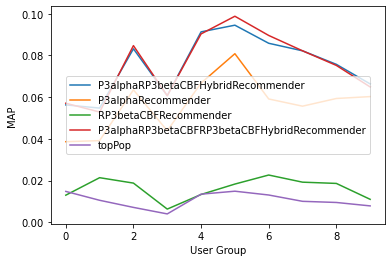

In [11]:
import matplotlib.pyplot as pyplot
%matplotlib inline

pyplot.plot(MAP_hybrid_per_group, label=p3alpha_featurecombinedrp3beta_recommender.RECOMMENDER_NAME)
pyplot.plot(MAP_p3alpha_per_group, label=p3alpha_recommender.RECOMMENDER_NAME)
pyplot.plot(MAP_featurecombinationRP3beta_per_group, label=RP3betaCBFRecommender.RECOMMENDER_NAME)
pyplot.plot(MAP_super_hyberid_per_group, label=p3alpha_featurecombinedrp3beta_rp3betacf_recommender.RECOMMENDER_NAME)
#pyplot.plot(MAP_pureSVDitem_per_group, label=pureSVDitem_recommender.RECOMMENDER_NAME)
# pyplot.plot(MAP_easer_per_group, label=easer_recommender.RECOMMENDER_NAME)
pyplot.plot(MAP_topPop_per_group, label="topPop")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()



In [2]:
URM_train


<7947x25975 sparse matrix of type '<class 'numpy.float64'>'
	with 90614 stored elements in Compressed Sparse Row format>

In [3]:
from src.Base.Recommender_utils import ratingMatrixTopK
from src.GraphBased.RP3betaCBFRecommender import RP3betaCBFRecommender
from src.Utils.ICM_preprocessing import *
ICM_combined = combine(ICM=ICM_all, URM = URM_train)
rp3betaCBF_recommender = RP3betaCBFRecommender(URM_train=URM_train, ICM_train=ICM_combined)
rp3betaCBF_recommender.fit(topK=586, alpha=0.4228, beta=0.1918, implicit=False)

URM_new = ratingMatrixTopK(rp3betaCBF_recommender.URM_train.dot(rp3betaCBF_recommender.W_sparse), k=10)

URM_new

RP3betaCBFRecommender: URM Detected 76 (0.96 %) cold users.
RP3betaCBFRecommender: URM Detected 2387 (9.19 %) cold items.
RP3betaRecommender: URM Detected 78 (0.28 %) cold users.
RP3betaRecommender: URM Detected 1 (0.00 %) cold items.


<7947x25975 sparse matrix of type '<class 'numpy.float32'>'
	with 79470 stored elements in Compressed Sparse Row format>

In [4]:
URM_in = rp3betaCBF_recommender.URM_train.dot(rp3betaCBF_recommender.W_sparse)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

from bayes_opt import BayesianOptimization

In [6]:
tuning_params = {
    "matrixTopK": (1, 100),
    "alpha": (0.1, 0.9),
    "beta": (0.1, 0.9),
    "cfTopK": (10, 600)
}


def BO_func(
        matrixTopK,
        alpha,
        beta,
        cfTopK
):

    URM_new = ratingMatrixTopK(URM_in, k=int(matrixTopK))
    rp3betaCBF_recommender = RP3betaCBFRecommender(URM_train=URM_train, ICM_train=URM_new.T, verbose=False)
    rp3betaCBF_recommender.fit(alpha=alpha, beta=beta,topK=int(cfTopK), implicit=False)
    result_dict, _ = evaluator_test.evaluateRecommender(rp3betaCBF_recommender)

    return result_dict[10]["MAP"]


optimizer = BayesianOptimization(
    f=BO_func,
    pbounds=tuning_params,
    verbose=5,
    random_state=5,
)

optimizer.maximize(
    init_points=10,
    n_iter=8,
)

|   iter    |  target   |   alpha   |   beta    |  cfTopK   | matrix... |
-------------------------------------------------------------------------
EvaluatorHoldout: Processed 5664 ( 100.00% ) in 3.40 sec. Users per second: 1667
|  1        |  4.99e-05 |  0.2776   |  0.7966   |  132.0    |  91.94    |
EvaluatorHoldout: Processed 5664 ( 100.00% ) in 3.36 sec. Users per second: 1685
|  2        |  6.52e-05 |  0.4907   |  0.5894   |  461.9    |  52.32    |
EvaluatorHoldout: Processed 5664 ( 100.00% ) in 3.13 sec. Users per second: 1811
|  3        |  3.315e-0 |  0.3374   |  0.2502   |  57.64    |  74.11    |
EvaluatorHoldout: Processed 5664 ( 100.00% ) in 3.25 sec. Users per second: 1742
|  4        |  0.000120 |  0.453    |  0.2266   |  529.2    |  28.13    |
EvaluatorHoldout: Processed 5664 ( 100.00% ) in 3.29 sec. Users per second: 1724
|  5        |  0.000110 |  0.4314   |  0.3369   |  381.0    |  58.4     |
EvaluatorHoldout: Processed 5664 ( 100.00% ) in 3.25 sec. Users per second: 1

KeyboardInterrupt: 